In [1]:
from mitoolspro.regressions import regime_models
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import requests
from pandas_datareader.data import DataReader

# Markov switching autoregression models from Statsmodels

https://www.statsmodels.org/stable/examples/notebooks/generated/markov_autoregression.html

This notebook provides an example of the use of Markov switching models in statsmodels to replicate a number of results presented in Kim and Nelson (1999). It applies the Hamilton (1989) filter the Kim (1994) smoother.

This is tested against the Markov-switching models from E-views 8, which can be found at http://www.eviews.com/EViews8/ev8ecswitch_n.html#MarkovAR or the Markov-switching models of Stata 14 which can be found at http://www.stata.com/manuals14/tsmswitch.pdf.

In [2]:
usrec = DataReader(
    "USREC", "fred", start=datetime(1947, 1, 1), end=datetime(2013, 4, 1)
)

## Hamilton (1989) switching model of GNP

This replicates Hamilton's (1989) seminal paper introducing Markov-switching models. The model is an autoregressive model of order 4 in which the mean of the process switches between two regimes. It can be written: $$y_t = \mu_{S_t} + \phi_{1}(y_{t-1} - \mu_{S_{t-1}}) + \phi_{2}(y_{t-2} - \mu_{S_{t-2}}) + \phi_{3}(y_{t-3} - \mu_{S_{t-3}}) + \phi_{4}(y_{t-4} - \mu_{S_{t-4}}) + \epsilon_t$$ Each period, the regime transitions according to the following matrix of transition probabilities: $$P(S_t = s_t | S_{t-1} = s_{t-1}) = \left[\begin{matrix} p_{00} & p_{10} \\ p_{01} & p_{11} \end{matrix}\right]$$ where $p_{ij}$ is the probability of transitioning from regime $i$ to regime $j$.

The model class is `MarkovAutoregression` in the time-series part of `statsmodels`. In order to create the model, we must specify the number of regimes with `k_regimes=2`, and the order of the autoregression with `order=4`. The default model also includes switching autoregressive coefficients, so here we also need to specify `switching_ar=False` to avoid that.

After creation, the model is `fit` via maximum likelihood estimation. Under the hood, good starting parameters are found using a number of steps of the expectation maximization (EM) algorithm, and a quasi-Newton (BFGS) algorithm is applied to quickly find the maximum.

<Axes: title={'center': 'Growth rate of Real GNP'}, xlabel='date'>

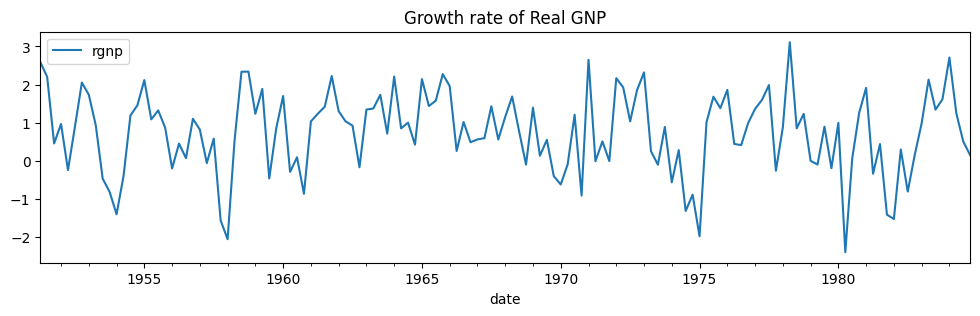

In [3]:
response = requests.get("https://www.stata-press.com/data/r14/rgnp.dta")
dta = pd.read_stata(BytesIO(response.content)).iloc[1:]

dta.index = pd.DatetimeIndex(dta.date, freq="QS")
dta_hamilton = dta[["rgnp"]]

dta_hamilton.plot(title="Growth rate of Real GNP", figsize=(12, 3))

In [4]:
mod_hamilton = regime_models.MarkovAutoregressionModel(data=dta_hamilton, dependent_variable="rgnp", order=4, k_regimes=2, switching_ar=False)
res_hamilton = mod_hamilton.fit()

In [5]:
res_hamilton.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                        y   No. Observations:                  131
Model:             MarkovAutoregression   Log Likelihood                -181.263
Date:                  Wed, 19 Mar 2025   AIC                            380.527
Time:                          20:18:04   BIC                            406.404
Sample:                               0   HQIC                           391.042
                                  - 131                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3588      0.265     -1.356      0.175      -0.877       0.160
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1635      0.075     15.614      0.000       1.017       1.310
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.5914      0.103      5.761      0.000       0.390       0.793
ar.L1          0.0135      0.120      0.112      0.911      -0.222       0.249
ar.L2         -0.0575      0.138     -0.418      0.676      -0.327       0.212
ar.L3         -0.2470      0.107     -2.310      0.021      -0.457      -0.037
ar.L4         -0.2129      0.111     -1.926      0.054      -0.430       0.004
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.7547      0.097      7.819      0.000       0.565       0.944
p[1->0]        0.0959      0.038      2.542      0.011       0.022       0.170
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

We plot the filtered and smoothed probabilities of a recession. Filtered refers to an estimate of the probability at time $t$ based on data up to and including time $t$ (but excluding time $t+1,...,T$). Smoothed refers to an estimate of the probability at time $t$ using all the data in the sample.

For reference, the shaded periods represent the NBER recessions.

In [6]:
filtered_probabilities = pd.DataFrame(res_hamilton.filtered_marginal_probabilities, columns = ["Recession", "Expansion"], index=dta_hamilton.index[4:])
smoothed_probabilities = pd.DataFrame(res_hamilton.smoothed_marginal_probabilities, columns = ["Recession", "Expansion"], index=dta_hamilton.index[4:])

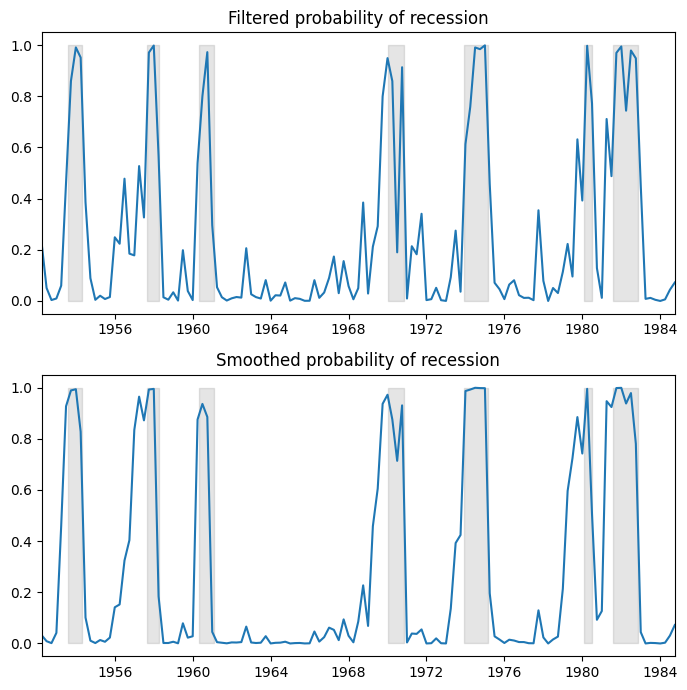

In [7]:
fig, axes = plt.subplots(2, figsize=(7, 7))
ax = axes[0]
ax.plot(filtered_probabilities.index, filtered_probabilities.Recession)
ax.fill_between(usrec.index, 0, 1, where=usrec["USREC"].values, color="k", alpha=0.1)
ax.set_xlim(dta_hamilton.index[4], dta_hamilton.index[-1])
ax.set(title="Filtered probability of recession")

ax = axes[1]
ax.plot(smoothed_probabilities.index, smoothed_probabilities.Recession)
ax.fill_between(usrec.index, 0, 1, where=usrec["USREC"].values, color="k", alpha=0.1)
ax.set_xlim(dta_hamilton.index[4], dta_hamilton.index[-1])
ax.set(title="Smoothed probability of recession")

fig.tight_layout()

From the estimated transition matrix we can calculate the expected duration of a recession versus an expansion.

In [8]:
print(res_hamilton.expected_durations)

[ 4.07604745 10.42589387]


In this case, it is expected that a recession will last about one year (4 quarters) and an expansion about two and a half years.

## Kim, Nelson, and Startz (1998) Three-state Variance Switching

This model demonstrates estimation with regime heteroskedasticity (switching of variances) and no mean effect. The dataset can be reached at http://econ.korea.ac.kr/~cjkim/MARKOV/data/ew_excs.prn.

The model in question is: $$y_t = \varepsilon_t$$ $$\varepsilon_t \sim N(0, \sigma_{S_t}^2)$$

Since there is no autoregressive component, this model can be fit using the `MarkovRegression` class. Since there is no mean effect, we specify `trend='n'`. There are hypothesized to be three regimes for the switching variances, so we specify `k_regimes=3` and `switching_variance=True` (by default, the variance is assumed to be the same across regimes).

<span style="color:red"> *Data source is not available. Made artifical data.*</span>

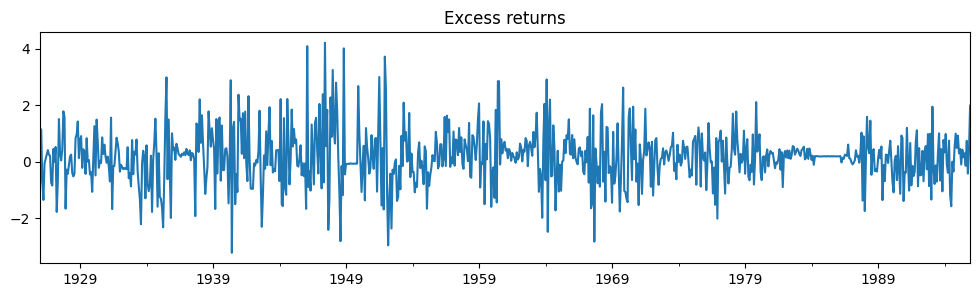

In [9]:
#ew_excs = requests.get("http://econ.korea.ac.kr/~cjkim/MARKOV/data/ew_excs.prn").content
#raw = pd.read_table(BytesIO(ew_excs), header=None, skipfooter=1, engine="python")

np.random.seed(42)  
n = 840
num_regimes = np.random.randint(50, 75)
cuts = np.sort(np.random.choice(range(1, n), size=num_regimes-1, replace=False))
segments_lengths = np.diff(np.concatenate(([0], cuts, [n])))
means = np.random.uniform(-0.25, 0.5, size=num_regimes)
stds = np.random.uniform(0.0, 1.5, size=num_regimes)
signal_segments = []
for length, mean, std in zip(segments_lengths, means, stds):
    segment = np.random.normal(mean, std, length)
    signal_segments.append(segment)

raw = np.concatenate(signal_segments)
index = pd.date_range("1926-01-01", "1995-12-01", freq="MS")

dta_kns = pd.DataFrame(raw, index=index, columns=["returns"])

_ = dta_kns["returns"].plot(title="Excess returns", figsize=(12, 3))

In [10]:
mod_kns = regime_models.MarkovRegressionModel(
    dta_kns, "returns", k_regimes=3, trend="n", switching_variance=True
)
res_kns = mod_kns.fit()

In [11]:
res_kns.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                  840
Model:               MarkovRegression   Log Likelihood               -1039.518
Date:                Wed, 19 Mar 2025   AIC                           2097.036
Time:                        20:18:05   BIC                           2139.637
Sample:                             0   HQIC                          2113.364
                                - 840                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0851      0.014      6.255      0.000       0.058       0.112
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.9540      0.223      8.777      0.000       1.518       2.390
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.5417      0.058      9.302      0.000       0.428       0.656
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9502      0.024     40.231      0.000       0.904       0.997
p[1->0]        0.0190      0.013      1.445      0.148      -0.007       0.045
p[2->0]        0.0043      0.007      0.631      0.528      -0.009       0.018
p[0->1]        0.0398      0.023      1.748      0.080      -0.005       0.084
p[1->1]        0.9507      0.021     44.677      0.000       0.909       0.992
p[2->1]        0.0180      0.012      1.445      0.149      -0.006       0.042
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

Below we plot the probabilities of being in each of the regimes; only in a few periods is a high-variance regime probable.

In [12]:
smoothed_probabilities = pd.DataFrame(res_kns.smoothed_marginal_probabilities, columns = ["Low", "Medium", "High"], index=dta_kns.index)

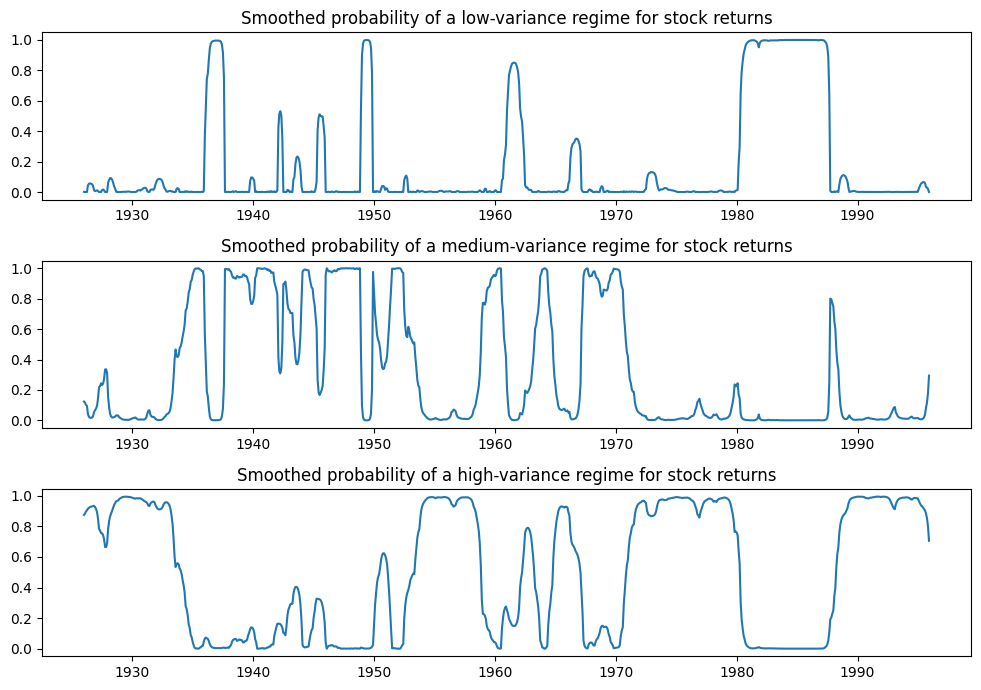

In [13]:
fig, axes = plt.subplots(3, figsize=(10, 7))

ax = axes[0]
ax.plot(smoothed_probabilities["Low"])
ax.set(title="Smoothed probability of a low-variance regime for stock returns")

ax = axes[1]
ax.plot(smoothed_probabilities["Medium"])
ax.set(title="Smoothed probability of a medium-variance regime for stock returns")

ax = axes[2]
ax.plot(smoothed_probabilities["High"])
ax.set(title="Smoothed probability of a high-variance regime for stock returns")

fig.tight_layout()

## Filardo (1994) Time-Varying Transition Probabilities

This model demonstrates estimation with time-varying transition probabilities. The dataset can be reached at http://econ.korea.ac.kr/~cjkim/MARKOV/data/filardo.prn.

In the above models we have assumed that the transition probabilities are constant across time. Here we allow the probabilities to change with the state of the economy. Otherwise, the model is the same Markov autoregression of Hamilton (1989).

Each period, the regime now transitions according to the following matrix of time-varying transition probabilities: $$P(S_t = s_t | S_{t-1} = s_{t-1}) = \left[\begin{matrix} p_{00,t} & p_{10,t} \\ p_{01,t} & p_{11,t} \end{matrix}\right]$$

where $p_{ij,t}$ is the probability of transitioning from regime $i$, to regime $j$, in period $t$, and is defined to be:

$$p_{ij,t} = \frac{\exp(x'_{t-1}\beta_{ij})}{1 + \exp(x'_{t-1}\beta_{ij})}$$

Instead of estimating the transition probabilities as part of maximum likelihood, the regression coefficients $\beta_{ij}$ are estimated. These coefficients relate the transition probabilities to a vector of pre-determined or exogenous regressors $x_{t-1}$.



<span style="color:red"> *Data source is not available. Made artifical data.*</span>

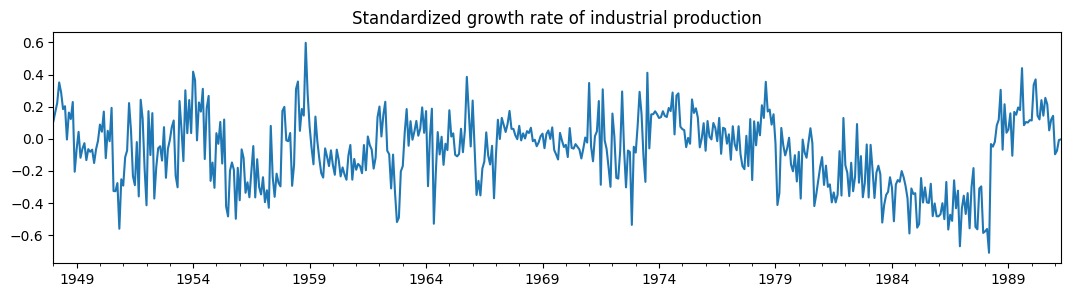

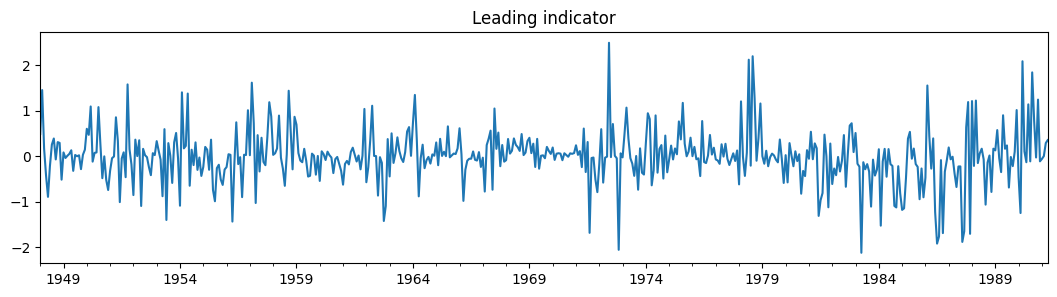

In [14]:
# filardo = requests.get("http://econ.korea.ac.kr/~cjkim/MARKOV/data/filardo.prn").content
# dta_filardo = pd.read_table(
#     BytesIO(filardo), sep=" +", header=None, skipfooter=1, engine="python"
# )
np.random.seed(42)
n = 520
num_regimes = np.random.randint(20, 50)
cuts = np.sort(np.random.choice(range(1, n), size=num_regimes-1, replace=False))
segments_lengths = np.diff(np.concatenate(([0], cuts, [n])))
means = np.random.uniform(-0.2, 0.2, size=num_regimes)
stds = np.random.uniform(0.05, 0.2, size=num_regimes)
slopes = np.random.uniform(-0.005, 0.0075, size=num_regimes)
signal_segments = []
for length, mean, std, slope in zip(segments_lengths, means, stds, slopes):
    t = np.arange(length)
    baseline = mean + slope * t
    segment = baseline + np.random.normal(0, std, length)
    signal_segments.append(segment)

raw = np.concatenate(signal_segments)
index = pd.date_range("1948-01-01", "1991-04-01", freq="MS")

dta_filardo = pd.DataFrame(raw, index=index, columns=["dlip"])

dta_filardo["dmdlleading"] = (dta_filardo["dlip"] - dta_filardo["dlip"].mean()) * np.random.normal(1.0, 2.5, len(dta_filardo))

_ = dta_filardo["dlip"].plot(
    title="Standardized growth rate of industrial production", figsize=(13, 3)
)
plt.figure()
_ = dta_filardo["dmdlleading"].plot(title="Leading indicator", figsize=(13, 3))

The time-varying transition probabilities are specified by the `exog_tvtp` parameter.

Here we demonstrate another feature of model fitting - the use of a random search for MLE starting parameters. Because Markov switching models are often characterized by many local maxima of the likelihood function, performing an initial optimization step can be helpful to find the best parameters.

Below, we specify that 20 random perturbations from the starting parameter vector are examined and the best one used as the actual starting parameters. Because of the random nature of the search, we seed the random number generator beforehand to allow replication of the result.

In [15]:
mod_filardo = regime_models.MarkovAutoregressionModel(dta_filardo.iloc[2:], 
                                            'dlip',
                                            k_regimes=2, 
                                            order=4, 
                                            switching_ar=False, 
                                            exog_tvtp=dta_filardo.iloc[1:-1][["dmdlleading"]])
np.random.seed(12345)
res_filardo = mod_filardo.fit(search_reps=20)

/Users/sebastian/Desktop/MontagnaInc/Projects/miToolsPro/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sebastian/Desktop/MontagnaInc/Projects/miToolsPro/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/sebastian/Desktop/MontagnaInc/Projects/miToolsPro/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
res_filardo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                        y   No. Observations:                  514
Model:             MarkovAutoregression   Log Likelihood                 204.493
Date:                  Wed, 19 Mar 2025   AIC                           -386.987
Time:                          20:18:07   BIC                           -340.322
Sample:                               0   HQIC                          -368.698
                                  - 514                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0984      0.032     -3.050      0.002      -0.162      -0.035
x1             0.2177        nan        nan        nan         nan         nan
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0597      0.032     -1.847      0.065      -0.123       0.004
x1             0.0948      0.011      8.901      0.000       0.074       0.116
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0251      0.002     14.170      0.000       0.022       0.029
ar.L1          0.2512      0.047      5.325      0.000       0.159       0.344
ar.L2          0.2289      0.048      4.774      0.000       0.135       0.323
ar.L3          0.1506      0.048      3.158      0.002       0.057       0.244
ar.L4          0.1602      0.047      3.423      0.001       0.068       0.252
                           Regime transition parameters                          
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
p[0->0].tvtp0     0.3722        nan        nan        nan         nan         nan
p[1->0].tvtp0    -0.4480        nan        nan        nan         nan         nan
=================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

Below we plot the smoothed probability of the economy operating in a low-production state, and again include the NBER recessions for comparison.

In [17]:
smoothed_probabilities = pd.DataFrame(res_filardo.smoothed_marginal_probabilities, columns = ["Low", "High"], index=dta_filardo.index[6:])

[Text(0.5, 1.0, 'Smoothed probability of a low-production state')]

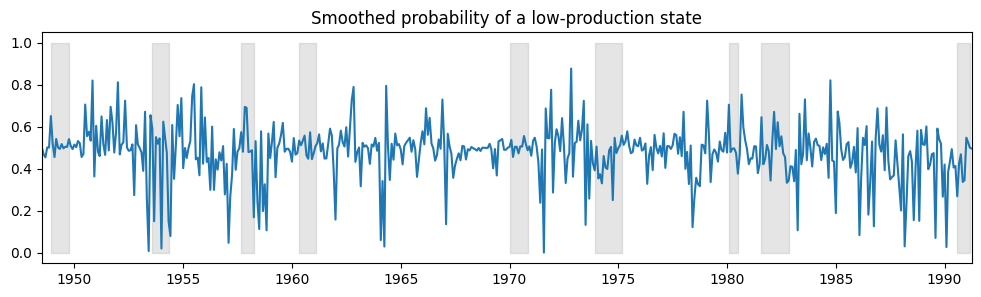

In [18]:
fig, ax = plt.subplots(figsize=(12, 3))

ax.plot(smoothed_probabilities["Low"])
ax.fill_between(usrec.index, 0, 1, where=usrec["USREC"].values, color="gray", alpha=0.2)
ax.set_xlim(dta_filardo.index[6], dta_filardo.index[-1])
ax.set(title="Smoothed probability of a low-production state")


Using the time-varying transition probabilities, we can see how the expected duration of a low-production state changes over time:

<Axes: title={'center': 'Expected duration of a low-production state'}>

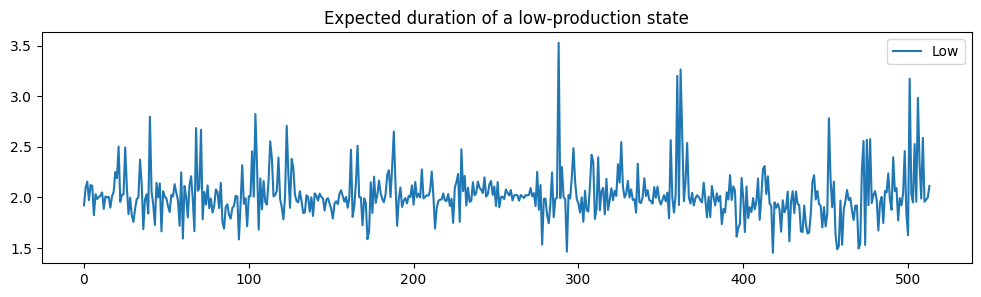

In [19]:
pd.DataFrame(res_filardo.expected_durations[:, 0], columns=["Low"]).plot(
    title="Expected duration of a low-production state", figsize=(12, 3)
)

***